In [1]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Reinforcement_learning/DQN')

In [2]:
from scheduler import LinearScheduler
from replay_buffer import ReplayBuffer, PrioritizedReplayBuffer

In [3]:
import numpy as np
import datetime
import gym
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from tensorflow import keras
from matplotlib import pyplot as plt

In [4]:
def get_network():
    input = layers.Input(shape=(n_states,))
    x = input
    x = layers.Dense(units=64, activation='relu', kernel_initializer=keras.initializers.he_normal())(x)
    x = layers.Dense(units=64, activation='relu', kernel_initializer=keras.initializers.he_normal())(x)
    x = layers.Dense(units=64, activation='relu', kernel_initializer=keras.initializers.he_normal())(x)
    output = layers.Dense(units=n_actions, activation='linear')(x)
    return models.Model(input, output)


def generate_action(state, epsilon):
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(q_network.predict(np.expand_dims(state, 0)))
    return action


def learn(beta=0):
    states, actions, rewards, next_states, dones, weights, indices = buffer.sample(batch_size, beta)

    target_values = np.max(target_network.predict(next_states), axis=1) * (1 - dones)
    target_values = rewards + gamma * target_values

    target = q_network.predict(states)
    target[np.arange(batch_size), actions] = target_values

    loss = q_network.train_on_batch(states, target, sample_weight=weights)

    error = target_values - target[np.arange(batch_size), actions]
    return error, loss, indices


def update_target():
    target_network.set_weights(q_network.get_weights())




n states: 4, n actions: 2
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 8,770
Trainable params: 8,770
Non-trainable params: 0
_________________________________________________________________
Model: "functional_3"
_________________________________________________________________
Laye

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode number: 100, step: 2312, epsilon: 0.95
reward: 31.0, mean reward: 26.3, error:1.0878050923566742e-06, loss:0.20603695511817932
*****************
Episode number: 200, step: 4329, epsilon: 0.9
reward: 14.0, mean reward: 20.5, error:1.1898035406205922e-06, loss:2.0685062408447266
*****************
Episode number: 300, step: 6140, epsilon: 0.86
reward: 11.0, mean reward: 16.7, error:1.248849391981665e-06, loss:3.7611355781555176
*****************
Episode number: 400, step: 8017, epsilon: 0.82
reward: 21.0, mean reward: 19.0, error:1.2466142177415255e-06, loss:1.424457311630249
*****************
Episode number: 500, step: 10622, epsilon: 0.76
reward: 59.0, mean reward: 33.2, error:1.423341989547188e-06, loss:0.4157077372074127
*****************
Episode number: 600, step: 14969, epsilon: 0.66
reward: 62.0, mean reward: 46.65, error:1.5569308998282231e-06, loss:0.3113645017147064
*****************
Episode number: 700, step: 20831, epsilon: 0.53
reward: 35.0, mean reward: 59.65, error:

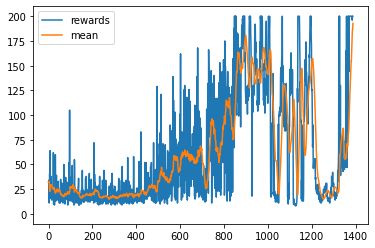

In [5]:
env = gym.make('CartPole-v0')

n_states = env.observation_space.shape[0]
n_actions = env.action_space.n

print(f'n states: {n_states}, n actions: {n_actions}')

# q_op = optimizers.Adam()

state = env.reset()
total_time_steps = 100000
episode = 1
episode_reward = 0
rewards = []
mean_rewards = [0]

exploration_fraction = 0.4
batch_size = 64
gamma = 0.99
lr = 0.0005

goal_reward = 190
prioritized = True
p_epsilon = 1e-6

alpha = 0.4
beta = 0

learning_start = 1000
update_interval = 500
print_interval = 100

buffer_size = 2 ** 19

epsilon_scheduler = LinearScheduler(initial_value=1, final_value=0.1,
                                    schedule_time_steps=int(total_time_steps * exploration_fraction))
if prioritized:
    buffer = PrioritizedReplayBuffer(buffer_size=buffer_size, alpha=alpha)
    beta_scheduler = LinearScheduler(initial_value=0.6, final_value=1.0, schedule_time_steps=total_time_steps)
else:
    buffer = ReplayBuffer(buffer_size=buffer_size)

q_network = get_network()
target_network = get_network()
q_network.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=lr))

q_network.summary()
target_network.summary()

for t in range(total_time_steps):
    epsilon = epsilon_scheduler.get_value(t)
    action = generate_action(state, epsilon)
    next_state, reward, done, _ = env.step(action)

    buffer.store(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward

    if done:
        mean_rewards.append(np.mean(rewards[-20:]))
        if episode % print_interval == 0:
            print(f'Episode number: {episode}, step: {t}, epsilon: {np.round(epsilon, 2)}\n'
                  f'reward: {episode_reward}, mean reward: {mean_rewards[-1]}, error:{np.mean(error)}, loss:{loss}')
            print('*****************')
        rewards.append(episode_reward)
        episode_reward = 0
        episode += 1

        state = env.reset()
        if prioritized:
            beta = beta_scheduler.get_value(t)
        error, loss, indices = learn(beta)
        if prioritized:
            error = np.abs(error) + p_epsilon
            buffer.update_priorities(error, indices=indices)

    if t % update_interval == 0:
        update_target()

    if mean_rewards[-1] >= goal_reward:
        print(f'final step: {t}, episode: {episode}, epsilon: {epsilon}, error:{np.mean(error)}, loss:{loss}')
        break

now = datetime.datetime.now()

with open('DQN_and_Per_log.txt', "a") as f:
    f.write(
        f'\nrun time: {now} if prioritized: {prioritized}, total steps: {total_time_steps}, exploration fraction: {exploration_fraction}'
        f'final step: {t}, episode: {episode}, epsilon: {epsilon}'
        f'lr: {lr}, batch size: {batch_size}, buffer size: {buffer_size}')

plt.plot(rewards, label='rewards')
plt.plot(mean_rewards, label='mean')
plt.legend()
plt.savefig(f'dqn_{round(mean_rewards[-1])}_prioritized_{prioritized}_time_{now}.jpg')
plt.show()